In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
import csv
import ast
# Score
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Dominant color
from PIL import Image
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import urllib.request
from sklearn.cluster import KMeans
from collections import Counter
# Parallel computing
from joblib import Parallel, delayed
import multiprocessing
import psutil
import time
# Stats
from scipy import stats

## Creation of the dataset

We have two datasets
 - Amazon Customer Review dataset :
   - amazon_reviews_us_Books_v1_00.tsv.gz (2.74 Go)
   - amazon_reviews_us_Books_v1_01.tsv.gz (2.69 Go)
   - amazon_reviews_us_Books_v1_02.tsv.gz (1.33 Go)
 - Amazon Book Cover dataset : 
   - book32-listing.csv (39.5 Mo)

Each row of the first dataset represents a review. Therefore we could have several rows representing the same book (several reviews for the same book). 

Each row of the second dataset represents a book. 

In this notebook, we merge the two datasets, in order to have each row of the new dataset representing a review, along with the cover of the corresponding book. 

Since the first dataset is pretty big, and to avoid creating a huge dataset, we will use the following pipeline : 
 - Load the cover file
 - Load the first review file
 - Merge the first review file in df_merge_1
 - Load the second review file
 - Merge the second review file in df_merge_2
 - Load the third review file
 - Merge the third review file in df_merge_3
 - Merge df_merge_1, df_merge_2, and df_merge_3 in df_merge
 - Save df_merge in merge.csv

First we load the cover image dataset

In [2]:
columns = ['product_id', 
           'filename', 
           'image_url', 
           'title', 
           'author', 
           'category_id', 
           'category']
df_covers = pd.read_csv("Data/book32-listing.csv", 
                        encoding = "ISO-8859-1", 
                        header=None, 
                        names=columns)
df_covers.head()

,product_id,filename,image_url,title,author,category_id,category
0,761183272,0761183272.jpg,http://ecx.images-amazon.com/images/I/61Y5cOdH...,Mom's Family Wall Calendar 2016,Sandra Boynton,3,Calendars
1,1623439671,1623439671.jpg,http://ecx.images-amazon.com/images/I/61t-hrSw...,Doug the Pug 2016 Wall Calendar,Doug the Pug,3,Calendars
2,B00O80WC6I,B00O80WC6I.jpg,http://ecx.images-amazon.com/images/I/41X-KQqs...,"Moleskine 2016 Weekly Notebook, 12M, Large, Bl...",Moleskine,3,Calendars
3,761182187,0761182187.jpg,http://ecx.images-amazon.com/images/I/61j-4gxJ...,365 Cats Color Page-A-Day Calendar 2016,Workman Publishing,3,Calendars
4,1578052084,1578052084.jpg,http://ecx.images-amazon.com/images/I/51Ry4Tsq...,Sierra Club Engagement Calendar 2016,Sierra Club,3,Calendars


We read the dataset containing the reviews. We have to specify the columns names because some rows have a higher count of cell than others. We want to see what is contained in these rows. 

In [3]:
cols = ["marketplace",
        "customer_id",
        "review_id",
        "product_id",
        "product_parent",
        "product_title",
        "product_category",
        "star_rating",
        "helpful_votes",
        "total_votes",
        "vine",
        "verified_purchase",
        "review_headline",
        "review_body",
        "review_date", 
        "undefined_1",
        "undefined_2",
        "undefined_3",
        "undefined_4",
        "undefined_5",
        "undefined_6",
        "undefined_7"
       ]

In [ ]:
df_reviews = pd.read_csv("Data/amazon_reviews_us_Books_v1_00.tsv.gz", 
                         names=cols, 
                         sep='\t', 
                         skiprows=1)

The warning simply indicates that some columns do not have the same dtype for each row, this will be handled later by cleaning the data.

So first we check the rows with a higher count of cells.

In [ ]:
df_reviews[df_reviews["undefined_1"].notnull()]

In [ ]:
# Compute the proportion of long row
null_mask = df_reviews["undefined_1"].notnull()
print(null_mask.sum() )
print((~null_mask).sum())

What is contained in the undefined columns is a bit weird, it's like we have more reviews, but they are not really related to the standard review column. For example, in the second line of the output, the review is "Was a great read..." and then we have "NOT PLEASED WITH THE VENDORS AT ALL" etc.

These lines are not clear concerning the reviews. We also try to find these reviews on the amazon website. We found some of them, but we were only able to find the main reviews, and not the reviews contained in the additional columns. Besides, these rows are not coherent concerning the columns (some values represents something else than expected by the column name). Since we only have 326 of such rows over 10 millions, we decide to drop these rows. We can also drop the additional column since we won't need them anymore. 

Finally, we drop some other columns that we don't need 

In [ ]:
df_reviews = df_reviews[~null_mask]
df_reviews = df_reviews.iloc[:, :15]
df_reviews = df_reviews.drop(['product_parent', 
                              'product_category', 
                              'vine', 
                              'verified_purchase'], axis=1)
df_reviews["product_id"] = df_reviews["product_id"].astype('str')

Now we want to merge the reviews dataset with the covers dataset, in other word, for each reviews, we want to have the cover image of the book. 

In [ ]:
df_merge_1 = df_reviews.merge(df_covers, 
                              left_on='product_id', 
                              right_on='product_id', 
                              how='inner')
null_mask = df_reviews["undefined_1"].notnull()
print(null_mask.sum() )
print((~null_mask).sum())
df_reviews = df_reviews[~null_mask]
df_reviews = df_reviews.iloc[:, :15]
df_reviews = df_reviews.drop(['product_parent', 
                              'product_category', 
                              'vine', 
                              'verified_purchase'], axis=1)
df_reviews["product_id"] = df_reviews["product_id"].astype('str')
df_merge_2 = df_reviews.merge(df_covers, 
                              left_on='product_id', 
                              right_on='product_id', 
                              how='inner')
print(len(df_merge_2))

In [ ]:
df_reviews = pd.read_csv("Data/amazon_reviews_us_Books_v1_02.tsv.gz", 
                         names=cols, 
                         sep='\t', 
                         skiprows=1)
null_mask = df_reviews["undefined_1"].notnull()
print(null_mask.sum() )
print((~null_mask).sum())
df_reviews = df_reviews[~null_mask]
df_reviews = df_reviews.iloc[:, :15]
df_reviews = df_reviews.drop(['product_parent', 
                              'product_category', 
                              'vine', 
                              'verified_purchase'], axis=1)
df_reviews["product_id"] = df_reviews["product_id"].astype('str')
df_merge_3 = df_reviews.merge(df_covers, 
                            left_on='product_id', 
                            right_on='product_id', 
                            how='inner')
print(len(df_merge_3))

In [ ]:
# append the dataframes
df_merge = df_merge_1.append(df_merge_2).append(df_merge_3)
# write the dataset
df_merge.to_csv("Data/merge.csv", sep='\t', index=False)

## Cleaning 

We have merged all the reviews dataset with the cover dataset. That means we have a dataframe where each line corresponds to a review. On top of the book review, we now also have the corresponding cover image. 

In [2]:
#Load the dataset
df = pd.read_csv("Data/merge.csv", sep='\t')

In [3]:
len(df)

1841789

Now we need to clean the columns

In [4]:
df.dtypes

marketplace         object
customer_id          int64
review_id           object
product_id          object
product_title       object
star_rating        float64
helpful_votes      float64
total_votes        float64
review_headline     object
review_body         object
review_date         object
filename            object
image_url           object
title               object
author              object
category_id          int64
category            object
dtype: object

In [5]:
# make sure we only have str type for the columns where dtype=object
df['marketplace'] = df['marketplace'].astype('str')
df['review_id'] = df['review_id'].astype('str')
df['product_id'] = df['product_id'].astype('str')
df['product_title'] = df['product_title'].astype('str')
df['review_headline'] = df['review_headline'].astype('str')
df['review_body'] = df['review_body'].astype('str')
df['review_date'] = df['review_date'].astype('str')
df['filename'] = df['filename'].astype('str')
df['image_url'] = df['image_url'].astype('str')
df['title'] = df['title'].astype('str')
df['author'] = df['author'].astype('str')
df['category'] = df['category'].astype('str')

In [6]:
df['marketplace'].value_counts()

US    1841789
Name: marketplace, dtype: int64

The marketplace is US only, so this column does not give us any information. We drop it. 

In [7]:
df = df.drop(['marketplace'], axis=1)

In [8]:
df['review_id'].is_unique

True

In [9]:
df['review_id'].isnull().values.any()

False

In [10]:
df['star_rating'] = df['star_rating'].astype('int64')
df['helpful_votes'] = df['helpful_votes'].astype('int64')
df['total_votes'] = df['total_votes'].astype('int64')

In [11]:
df['review_date'] = pd.to_datetime(df['review_date'], format='%Y-%m-%d')

In [12]:
df.dtypes

customer_id                 int64
review_id                  object
product_id                 object
product_title              object
star_rating                 int64
helpful_votes               int64
total_votes                 int64
review_headline            object
review_body                object
review_date        datetime64[ns]
filename                   object
image_url                  object
title                      object
author                     object
category_id                 int64
category                   object
dtype: object

In [13]:
df.groupby(['product_id'])['review_id'].count()

product_id
000215949X    61
000255206X     1
000255268X     1
000255710X     2
000638692X     1
000712032X     7
000712693X    14
000713326X    53
000714685X     1
000714704X     1
000716050X     7
000726285X     1
000731969X     5
000733169X    31
000743796X     7
000752417X     3
000754541X    10
000755303X     1
000755589X    12
000787376X    30
002041840X     6
002079990X    31
002346450X     5
002573900X     9
002603641X     5
002860881X     1
002861917X    21
002862405X     1
002863196X    29
002863974X     9
              ..
B00FM9ZQ9Y     6
B00G2MH8NM    10
B00G3JKXKE     1
B00G6T9ZZA     2
B00GH0W88Y     5
B00GOHVFQ6    18
B00H4O605E     3
B00HALWVMC     9
B00HTJQK5O     1
B00HV4XOLA     1
B00IN8US6M     1
B00JTNW0BQ     6
B00K5SDL3A     6
B00K7FVC0A     3
B00K7RDSAA     6
B00LLAI0Y6     5
B00NI97N2S     1
B00NSR57VY     3
B00O80WBYQ     6
B00O80WBZA     5
B00O80WBZK     4
B00O80WBZU    14
B00O80WC18    12
B00O80WC1S     2
B00O80WC2C     4
B00O80WC7C     2
B00O80WCCM     2
B00

We can see that some books have only one or two reviews so we decided to keep only the books that had at least 5 reviews in order for the ratings to be relevant and based on several opinions.

In [14]:
dffiltered = df.groupby(['product_id'])['product_id','review_id'].filter(lambda reviews: len(reviews) > 4)
ids_to_keep = dffiltered['product_id'].unique()

In [15]:
df = df[df['product_id'].isin(ids_to_keep)]

In [16]:
df.to_csv("Data/cleaned.csv", sep='\t', index=False)

## Dataset Description

In [17]:
df = pd.read_csv("Data/cleaned.csv", sep='\t')
# datetime are not store in the csv
df['review_date'] = pd.to_datetime(df['review_date'], format='%Y-%m-%d')

In [18]:
# size of dataset
len(df)

1786163

In [19]:
# number of books
len(df['product_id'].unique())

47976

In [20]:
# number of covers
print(len(df['image_url'].unique()))


47963


In [21]:
# number of categories
len(df['category_id'].unique())
urls_duplicate_product_ids = []
for group in df.groupby(['image_url'])['product_id']:
    #print(group[0], list(group[1]))
    if len(set(list(group[1]))) > 1:
        urls_duplicate_product_ids.append(group[0])
# we can see that the same url is used for two product_id because they are two different volumes
df[df['image_url'] == urls_duplicate_product_ids[4]]['product_title'].unique()

array(['The Pocket Calorie Counter, 2014 Edition (Portable Diet Guide)',
       'Pocket Calorie Counter, 2015 Edition'], dtype=object)

In [22]:
# star rating distribution
ratings = df['star_rating'].value_counts().sort_index()

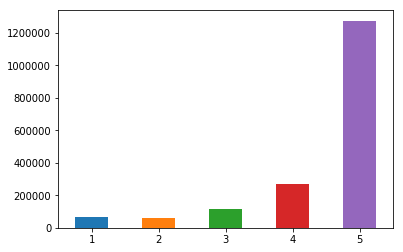

In [23]:
ratings.plot.bar(rot=0)

In [24]:
ratings[5] / ratings.sum()

0.7133430711530806

In [25]:
(ratings[4] + ratings[5]) / ratings.sum()

0.8642363546887938

We see that most of people gives a 5-star rating. This is a problem because it will be hard to make statistics using ratings if all books are considered very good. We will try to overcome this issue by computing a new rating using only text reviews. We will need to use text classification and machine learning for this purpose. 

Now let's have a look to the review date distribution. 

In [26]:
review_years = df['review_date'].dropna().apply(lambda x: int(x.year)).value_counts()

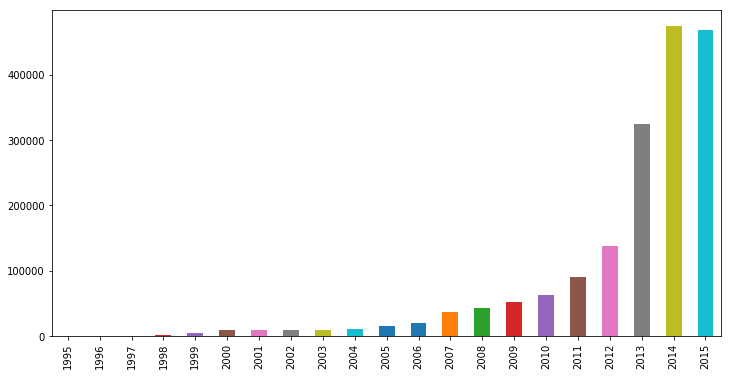

In [27]:
review_years.sort_index().plot.bar(figsize=(12, 6))

We will need to be careful when analysing the evolution of reviews over time because we don't have much reviews for the reviews count increases exponentially over time. One the cause may be the increasing publication of books over time, which is not a problem for us. What could be a problem is that this review distribution may also be due on one hand by the increasing importance of Amazon, and on the second hand by the democratization of internet, which allows more people to give reviews. So we will need to be careful for example if we want to compare the average rating in 1995 and the average rating in 2015, because the reviews count on both side is very different.

## Methodology

In [28]:
df = pd.read_csv("Data/cleaned.csv", sep='\t')
# datetime are not store in the csv
df['review_date'] = pd.to_datetime(df['review_date'], format='%Y-%m-%d')

### Reviews Scores

Add score obtained with vader sentiment analyser

http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

Too many reviews had 5 stars (maximal grade), so it wasn't so relevant to help us distinguish. 
Using VADER, we found a new score based on the intensity of sentiment (negative, neutral, positive) of the reviews. We weighted the old score of the review by this score (50\% was attributed to the star rating and 50\% to the sentiment score). This vader score was between -1 (very negative) and 1 (very positive) so we shifted it between 0.5 and 5.5 so that we obtain final scores between 1 and 5. The first part has been commented as it took 2 hours to run.

In [38]:
analyzer = SentimentIntensityAnalyzer()
# The compound score, is the sum of all of the lexicon ratings ('neg', 'neu', 'pos')
# which have been standardised to range between -1 and 1.

#df['vader_score'] = df['review_body'].apply(lambda review: analyzer.polarity_scores(review)['compound'])
#df['vader_score_5'] = (df['vader_score']+1)*2.5+0.5

In [72]:
df = pd.read_csv("Data/vader.csv", sep='\t')

In [73]:
df['vader_score_5'].corr(df['star_rating'])

0.34642005726517217

In [74]:
df['star_rating'].value_counts()

5    1274147
4     269520
3     114276
1      68966
2      59254
Name: star_rating, dtype: int64

In [75]:
df['rating_adjusted'] = df['vader_score_5']*0.5 + df['star_rating']*0.5
df['rating_adjusted'] = df['rating_adjusted'].apply(lambda x: round(x))
df['rating_adjusted'].value_counts()

5    1227331
4     342620
3     128889
2      58621
1      28702
Name: rating_adjusted, dtype: int64

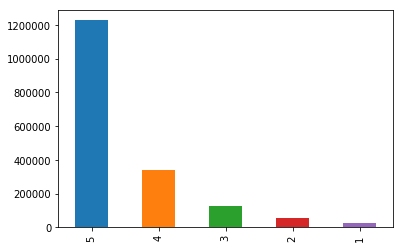

In [76]:
df['rating_adjusted'].value_counts().plot(kind='bar')

In [77]:
len(df[df['review_body'].astype('str').apply(lambda x: len(x) < 10)])

45336

In [78]:
df.to_csv("Data/vader.csv", sep='\t', index=False)

### Covers dominant colors

Find dominant colors of the book covers
https://adamspannbauer.github.io/2018/03/02/app-icon-dominant-colors/

Distance between two colors
http://hanzratech.in/2015/01/16/color-difference-between-2-colors-using-python.html

20 disctinct simple colors
https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/

We first had to find the dominant colors of every book cover. To do so we used sklearn.cluster.Kmeans with a Kmeans of ten which provided the best results and was the most stable (when launching several times, we obtained the same results independant of the initial random points.) However, finding the dominants colors take between 4 and 10 seconds. Therefore, we had to distribute the work and launch several program in parallel on different parts of the data set. We decided to take the two most dominant colors. This part is commented as it was done separetly in a .py file.

In [79]:
def calculate_colors(url):
    url_dominant_rgb = {}
    try:
        image = Image.open(urllib.request.urlopen(url))
        if image.mode != "RGB":
            image = image.convert("RGB")
        image = np.array(image,dtype=np.uint8)

        image = image.reshape((image.shape[0] * image.shape[1], 3))
        clt = KMeans(n_clusters = 10)
        labels = clt.fit_predict(image)
        label_counts = Counter(labels)
        common = label_counts.most_common(2)
        dominant_color = list(clt.cluster_centers_[common[0][0]])
        dominant_color1 = list(clt.cluster_centers_[common[1][0]])

        dominant_color = np.rint(dominant_color).astype(int)
        dominant_color1 = np.rint(dominant_color1).astype(int)
        url_dominant_rgb[url] = [dominant_color, dominant_color1]
        return url_dominant_rgb
    except:
        url_dominant_rgb[url] = None
        return url_dominant_rgb

In [80]:
urls = df['image_url'].unique()
np.save('urls', urls)

In [81]:
#urls = np.load('Data/urls.npy')[:10000]

#print(multiprocessing.cpu_count())

#results = Parallel(n_jobs=multiprocessing.cpu_count())(map(delayed(calculate_colors), urls))

#results = {k: v for d in results for k, v in d.items()}

#with open('urls_rgb.csv', 'w') as csv_file:
#    writer = csv.writer(csv_file)
#    for key, value in results.items():
#       writer.writerow([key, value])

Examples showing the three first dominant colors for different covers. After seeing this we decided to keep two dominant colors. See report for more details

In [82]:
def get_dominant_color(image, k=10):
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    common = label_counts.most_common(3)
    dominant_color = clt.cluster_centers_[common[0][0]]
    dominant_color1 = clt.cluster_centers_[common[1][0]]
    dominant_color2 = clt.cluster_centers_[common[2][0]]

    return list(dominant_color), list(dominant_color1), list(dominant_color2)

In [83]:
img_url = 'http://ecx.images-amazon.com/images/I/51K8hp-Pr5L.jpg'
img_url2 = 'http://ecx.images-amazon.com/images/I/41AI1C1csVL.jpg'
img_url3 = 'http://ecx.images-amazon.com/images/I/51GO%2BsxPFrL.jpg'
img_url4 = 'http://ecx.images-amazon.com/images/I/510FNRDBX1L.jpg'

In [84]:
image = Image.open(urllib.request.urlopen(img_url))
dominants = get_dominant_color(np.array(image))
dominant_color00 = np.rint(dominants[0]).astype(int)
dominant_color10 = np.rint(dominants[1]).astype(int)
dominant_color20 = np.rint(dominants[2]).astype(int)

image2 = Image.open(urllib.request.urlopen(img_url2))
dominants = get_dominant_color(np.array(image2))
dominant_color01 = np.rint(dominants[0]).astype(int)
dominant_color11 = np.rint(dominants[1]).astype(int)
dominant_color21 = np.rint(dominants[2]).astype(int)

image3 = Image.open(urllib.request.urlopen(img_url3))
dominants = get_dominant_color(np.array(image3))
dominant_color02 = np.rint(dominants[0]).astype(int)
dominant_color12 = np.rint(dominants[1]).astype(int)
dominant_color22 = np.rint(dominants[2]).astype(int)

image4 = Image.open(urllib.request.urlopen(img_url4))
dominants = get_dominant_color(np.array(image4))
dominant_color03 = np.rint(dominants[0]).astype(int)
dominant_color13 = np.rint(dominants[1]).astype(int)
dominant_color23 = np.rint(dominants[2]).astype(int)

In [85]:
def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)

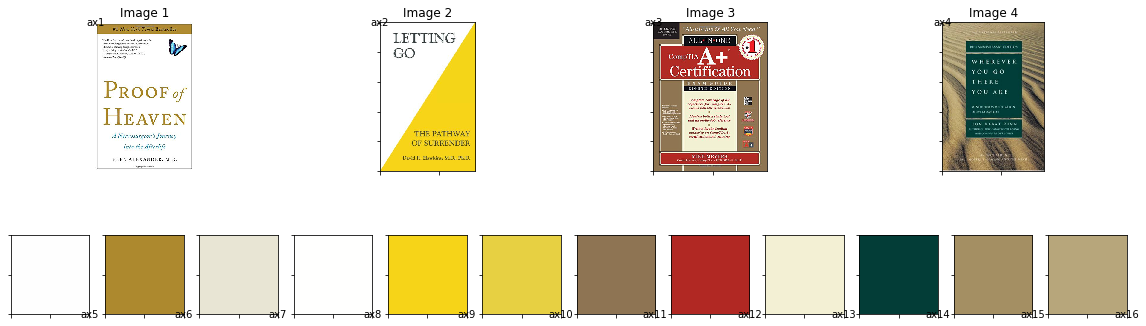

In [97]:
w=10
h=10
fig=plt.figure(figsize=(20, 6))
ax1 = plt.subplot2grid((2, 12), (0, 0), colspan=3)
ax1.set_axis_off()
plt.sca(ax1)
plt.title("Image 1")
plt.imshow(image)
ax2 = plt.subplot2grid((2, 12), (0, 3), colspan=3)
plt.sca(ax2)
plt.title("Image 2")
plt.imshow(image2)
ax3 = plt.subplot2grid((2, 12), (0, 6), colspan=3)
plt.sca(ax3)
plt.title("Image 3")
plt.imshow(image3)
ax4 = plt.subplot2grid((2, 12), (0, 9), colspan=3)
plt.sca(ax4)
plt.title("Image 4")
plt.imshow(image4)

ax11 = plt.subplot2grid((2, 12), (1, 0))
plt.sca(ax11)
plt.imshow(([[dominant_color00]]))
ax12 = plt.subplot2grid((2, 12), (1, 1))
plt.sca(ax12)
plt.imshow(([[dominant_color10]]))
ax13 = plt.subplot2grid((2, 12), (1, 2))
plt.sca(ax13)
plt.imshow(([[dominant_color20]]))

ax21 = plt.subplot2grid((2, 12), (1, 3))
plt.sca(ax21)
plt.imshow(([[dominant_color01]]))
ax22 = plt.subplot2grid((2, 12), (1, 4))
plt.sca(ax22)
plt.imshow(([[dominant_color11]]))
ax23 = plt.subplot2grid((2, 12), (1, 5))
plt.sca(ax23)
plt.imshow(([[dominant_color21]]))

ax31 = plt.subplot2grid((2, 12), (1, 6))
plt.sca(ax31)
plt.imshow(([[dominant_color02]]))
ax32 = plt.subplot2grid((2, 12), (1, 7))
plt.sca(ax32)
plt.imshow(([[dominant_color12]]))
ax33 = plt.subplot2grid((2, 12), (1, 8))
plt.sca(ax33)
plt.imshow(([[dominant_color22]]))

ax41 = plt.subplot2grid((2, 12), (1, 9))
plt.sca(ax41)
plt.imshow(([[dominant_color03]]))
ax42 = plt.subplot2grid((2, 12), (1, 10))
plt.sca(ax42)
plt.imshow(([[dominant_color13]]))
ax43 = plt.subplot2grid((2, 12), (1, 11))
plt.sca(ax43)
plt.imshow(([[dominant_color23]]))

make_ticklabels_invisible(plt.gcf())
fig.show()
fig.savefig("outfig.png", bbox_inches='tight')

We then needed to find a way to classify the dominant colors found in the previous step into categories. As we are interested in how people perceived the colors of the cover, we decided to represent the colors using the CIELAB color space implemented in the colormath library. Lab color is designed to approximate human vision.

In [98]:
colors_dict = {
    "#ff0000": "Red",
    "#f58231": "Orange",
    "#ffff00": "Yellow",
    "#00ff00": "Lime",
    "#008000": "Green",
    "#42d4f4": "Cyan",
    "#0000ff": "Blue",
    "#911eb4": "Purple",
    "#f032e6": "Magenta",
    "#a9a9a9": "Grey",
    "#000000": "Black",
    "#ffffff": "White",
    "#800000": "Maroon",
    "#9a6324": "Brown",
    "#469990": "Teal",
    "#000075": "Navy"
}
colors = list(colors_dict.keys())
colors_lab_dict = {}
for color in colors:
    colors_lab_dict[convert_color(sRGBColor.new_from_rgb_hex(color), LabColor)] = color
colors_srgbcolor = [sRGBColor.new_from_rgb_hex(color) for color in colors]

In [99]:
#url_dominant = {}
#for url in results.keys():
#    dominant_colors = []
#    if results[url] is not None:
#        for dominant_color in results[url]:
#            srgb_dominant = sRGBColor(*dominant_color/255)
#            dominant_lab = convert_color(srgb_dominant, LabColor)
#            min_delta = float("inf")
#            color = ''
#            for color_lab in colors_lab_dict.keys():
#                delta = delta_e_cie2000(dominant_lab, color_lab)
#                if delta < min_delta:
#                    min_delta = delta
#                    color = colors_lab_dict[color_lab]
#            dominant_colors.append(color)
#    url_dominant[url] = dominant_colors

#with open('Data/urls_total.csv', 'w') as csv_file:
#    writer = csv.writer(csv_file)
#    for key, value in url_dominant.items():
#       writer.writerow([key, value])


In [100]:
df = pd.read_csv("Data/urls_total.csv", sep=',', header=None, names=['Urls', 'DominantColors'])

In [101]:
all_urls = {}
dict_urls = df.set_index('Urls')['DominantColors'].to_dict()
dict_urls = dict((k, ast.literal_eval(v)) for k, v in dict_urls.items())
all_urls.update(dict_urls)

In [102]:
df = pd.read_csv("Data/vader.csv", sep='\t')
df['dominant_color1'] = df['image_url'].apply(lambda url: all_urls[url][0])
df['dominant_color2'] = df['image_url'].apply(lambda url: all_urls[url][1])
df.to_csv('Data/dataset-augmented.csv', sep='\t', encoding='utf-8', index=False)

## Results

In [2]:
df = pd.read_csv("Data/dataset-augmented.csv", sep='\t')
# datetime are not store in the csv
df['review_date'] = pd.to_datetime(df['review_date'], format='%Y-%m-%d')

### Influence of book covers

In [3]:
colors_dict = {
    "#ff0000": "Red",
    "#f58231": "Orange",
    "#ffff00": "Yellow",
    "#00ff00": "Lime",
    "#008000": "Green",
    "#42d4f4": "Cyan",
    "#0000ff": "Blue",
    "#911eb4": "Purple",
    "#f032e6": "Magenta",
    "#a9a9a9": "Grey",
    "#000000": "Black",
    "#ffffff": "White",
    "#800000": "Maroon",
    "#9a6324": "Brown",
    "#469990": "Teal",
    "#000075": "Navy"
}
colors = list(colors_dict.keys())
colors_srgbcolor = [sRGBColor.new_from_rgb_hex(color) for color in colors]

In [4]:
def get_color_name(color):
    return colors_dict[color]

In [5]:
colors_per_rating = dict()
for i in range(1, 6):
    colors_per_rating[i] = dict()
    for color in colors_dict:
        colors_per_rating[i][color] = 0

In [6]:
#for i in range(len(df)):
#    colors_per_rating[df['rating_adjusted'][i]][df['dominant_color1'][i]] += 1
#    colors_per_rating[df['rating_adjusted'][i]][df['dominant_color2'][i]] += 1

In [7]:
#np.save("colors_per_rating.npy", colors_per_rating)

In [8]:
colors_per_rating = np.load("colors_per_rating.npy")
colors_per_rating = colors_per_rating.item()

In [9]:
total = 0
for star in range(1, 6):
    for key in colors_per_rating[star]:
        total += colors_per_rating[star][key]
print(total)

4168778


In [10]:
star=5
total=0
for key in colors_per_rating[star]:
    print(key, colors_per_rating[star][key])
    total+=colors_per_rating[star][key]
print("Total: " + str(total))
print(total/(2*len(df)))

#ff0000 105991
#f58231 111665
#ffff00 148876
#00ff00 16038
#008000 57246
#42d4f4 81258
#0000ff 90655
#911eb4 45353
#f032e6 14437
#a9a9a9 224073
#000000 680797
#ffffff 882093
#800000 139602
#9a6324 109698
#469990 72633
#000075 84777
Total: 2865192
0.8020522203180784


In [11]:
(colors_per_rating[5]["#000000"] + colors_per_rating[5]["#ffffff"]) / total

0.5454747884260461

In [12]:
color_df = pd.DataFrame()
colors_5 = sorted(colors_per_rating[5].items())
x5, y5 = zip(*colors_5) 
color_df["Color"] = x5
color_df["5-star count"] = y5
color_df["5-star count"] = color_df["5-star count"] / color_df["5-star count"].sum()
colors_1 = sorted(colors_per_rating[1].items())
x1, y1 = zip(*colors_1) 
color_df["1-star count"] = y1
color_df["1-star count"] = color_df["1-star count"] / color_df["1-star count"].sum()
color_df = color_df.set_index(["Color"], drop=True)
color_df

,5-star count,1-star count
Color,,
#000000,0.237610,0.274279
#000075,0.029589,0.032635
#0000ff,0.031640,0.029463
#008000,0.019980,0.013361
#00ff00,0.005598,0.006107
#42d4f4,0.028360,0.024473
#469990,0.025350,0.019751
#800000,0.048723,0.047054
#911eb4,0.015829,0.014865


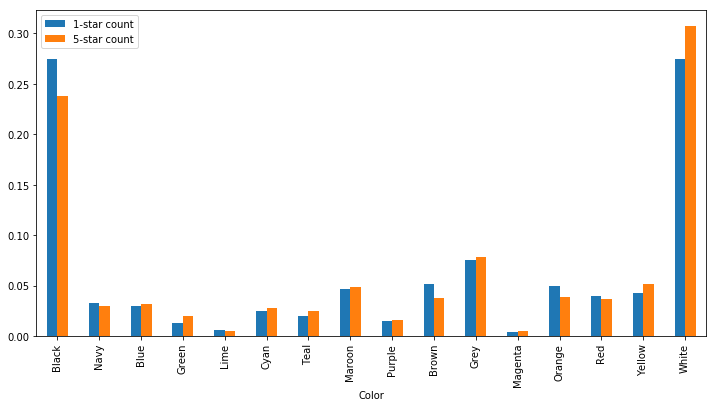

In [13]:
color_labels = list(color_df.index.map(get_color_name))
ax = color_df[["1-star count", "5-star count"]].plot(kind="bar", figsize=(12, 6))
_ = ax.set_xticklabels(color_labels)

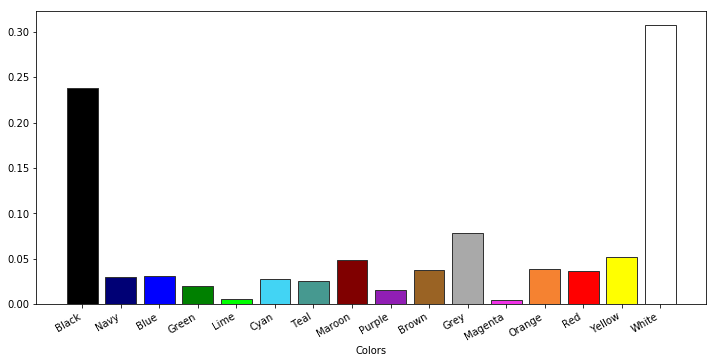

In [14]:
fig,ax = plt.subplots(1, figsize=(12, 6))
plt.bar(color_df.index, color_df["5-star count"], color=color_df.index, edgecolor="#333333")
fig.autofmt_xdate()
ax.set_xlabel("Colors")
_ = ax.set_xticklabels(color_labels)
plt.show()

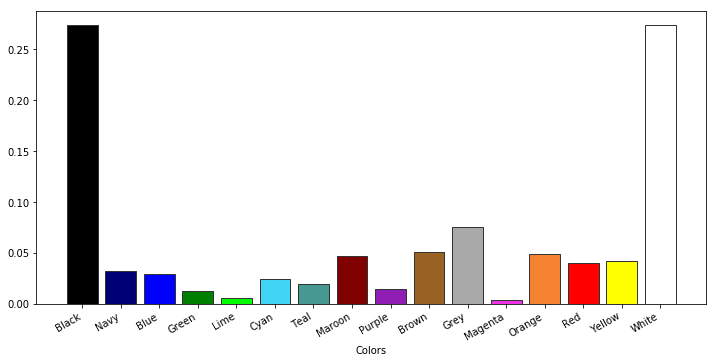

In [15]:
fig,ax = plt.subplots(1, figsize=(12, 6))
plt.bar(color_df.index, color_df["1-star count"], color=color_df.index, edgecolor="#333333")
fig.autofmt_xdate()
ax.set_xlabel("Colors")
_ = ax.set_xticklabels(color_labels)
plt.show()

In [16]:
color_df["Difference"] = color_df["5-star count"] -color_df["1-star count"]

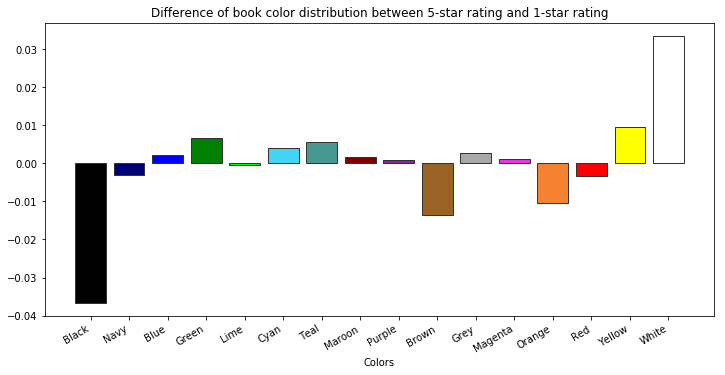

In [17]:
fig,ax = plt.subplots(1, figsize=(12, 6))
plt.bar(color_df.index, color_df["Difference"], color=color_df.index, edgecolor="#333333")
fig.autofmt_xdate()
ax.set_xlabel("Colors")
ax.set_title("Difference of book color distribution between 5-star rating and 1-star rating")
_ = ax.set_xticklabels(color_labels)
plt.show()

From this bar chart, we can observe different things. 

First, it appears that black and red color are more present when the rating is low. In the psychology of colors, red and black are related to darkness, agressiveness, while blue and green are related to something more peaceful. We can indeed see that green and blue are more present in the 5-star ratings, and black and red in the 1-star ratings. 

Second, on the same line, it appears that bright colors seem more related to high ratings and dark colors to low ratings. Let's explore this idea. From the colors, we will compute the brightness for each class (low and high ratings). 

This part was run in a separate .py

In [18]:
def perceived_brightness(url):
    url_brightness = {}
    try:
        b = Image.open(urllib.request.urlopen(url))
        b = np.array(b, dtype=np.float64)
        b = b*b
        b = b * np.array([0.299, 0.587, 0.114])
        b = b.sum(axis=2)
        b = np.sqrt(b)
        url_brightness[url] = b.mean()
        return url_brightness
    except:
        url_brightness[url] = -1.0
        return url_brightness

In [20]:
#urls = np.load('urls.npy')

#print(multiprocessing.cpu_count())

#results = Parallel(n_jobs=multiprocessing.cpu_count())(map(delayed(perceived_brightness), urls))

#results = {k: v for d in results for k, v in d.items()}

#with open('Data/url_to_brightness.csv.csv', 'w') as csv_file:
#    writer = csv.writer(csv_file)
#    for key, value in results.items():
#        writer.writerow([key, value])

#print(len(results))

In [22]:
with open('Data/url_to_brightness.csv', 'r') as f:
    reader = csv.reader(f)
    url_to_brightness = dict(reader)
    df['brightness'] = df['image_url'].apply(lambda url: url_to_brightness[url])
    df['brightness'] = df["brightness"].astype(np.float64)

In [23]:
url = df['image_url'][20000]
image = Image.open(urllib.request.urlopen(url))

In [24]:
hsl = np.array(image, dtype=np.float64)
max_b = np.max(hsl, axis=2)
min_b = np.min(hsl, axis=2)
hsl = (max_b+min_b)/2.0
hsl = np.array(Image.fromarray(hsl).convert("RGB"))

In [25]:
b = np.array(image, dtype=np.float64) 
b = b*b
b = b * np.array([0.299, 0.587, 0.114])
b = b.sum(axis=2)
b = np.sqrt(b)
b = np.array(Image.fromarray(b).convert("RGB"))

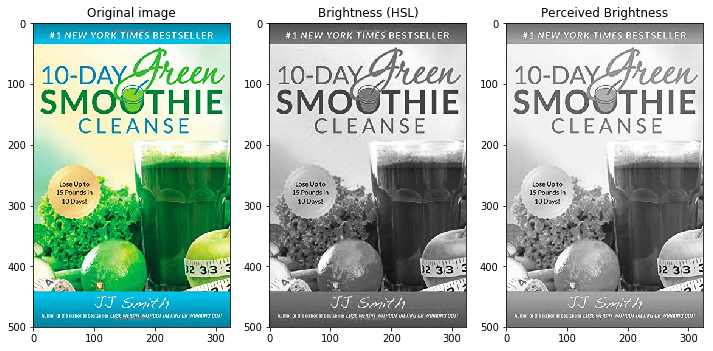

In [26]:
w=10
h=10
fig=plt.figure(figsize=(12, 6))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title("Original image")
plt.imshow(image)
fig.add_subplot(rows, columns, 2)
plt.title("Brightness (HSL)")
plt.imshow(hsl)
fig.add_subplot(rows, columns, 3)
plt.title("Perceived Brightness")
plt.imshow(b)
plt.show()

In [27]:
brightness1 = df[df["rating_adjusted"] == 1]["brightness"]
brightness5 = df[df["rating_adjusted"] == 5]["brightness"]

In [28]:
print("Brightness : ")
print("1-star : " + str(brightness1.mean()))
print("5-star : " + str(brightness5.mean()))

Brightness : 
1-star : 138.357392953682
5-star : 143.7162971333906


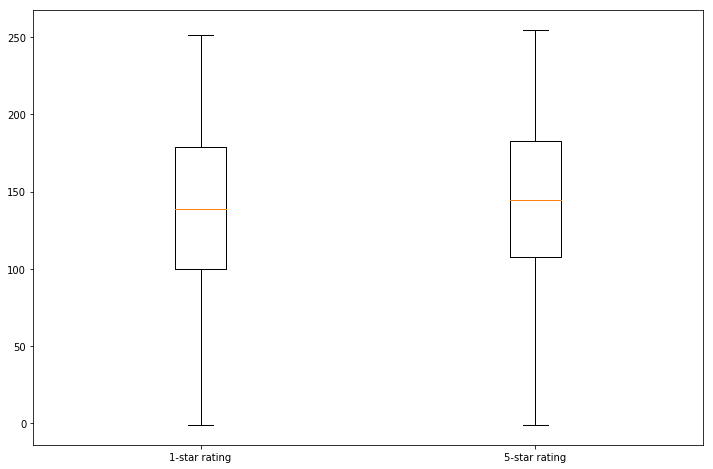

In [29]:
plt.figure(figsize=(12,8))
_ = plt.boxplot([brightness1, brightness5], labels=["1-star rating", "5-star rating"])

In [33]:
p_value = stats.levene(brightness1, brightness5)
p_value

LeveneResult(statistic=127.03274004945563, pvalue=1.8333103324936827e-29)

In [34]:
stats.ttest_ind(brightness1, brightness5, equal_var=False)

Ttest_indResult(statistic=-17.536525041373757, pvalue=1.659904023063165e-68)

### Influence of book categories

In [35]:
df["category"].unique()

array(['Romance', "Children's Books", 'Computers & Technology',
       'Sports & Outdoors', 'Test Preparation', 'Self-Help',
       'Crafts, Hobbies & Home', 'Christian Books & Bibles', 'Travel',
       'Humor & Entertainment', 'Literature & Fiction',
       'Arts & Photography', 'Cookbooks, Food & Wine',
       'Biographies & Memoirs', 'Health, Fitness & Dieting',
       'Engineering & Transportation', 'Politics & Social Sciences',
       'Science & Math', 'Science Fiction & Fantasy',
       'Mystery, Thriller & Suspense', 'Parenting & Relationships',
       'Calendars', 'Education & Teaching', 'Law', 'Medical Books',
       'Business & Money', 'History', 'Comics & Graphic Novels',
       'Reference', 'Teen & Young Adult', 'Religion & Spirituality',
       'Gay & Lesbian'], dtype=object)

In [36]:
# Average rating per category
rating_per_cat = df.groupby(["category"])["rating_adjusted"].mean().sort_values()

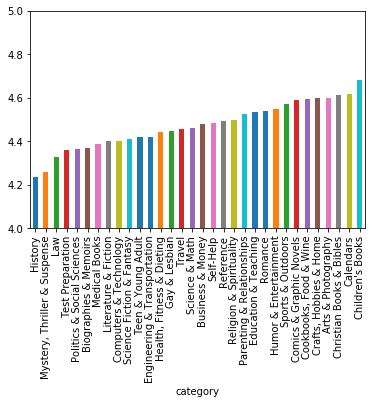

In [37]:
plt.ylim(4, 5)
rating_per_cat.plot(kind="bar")

In [38]:
df_cat = df.groupby(["product_id"])["category"].unique().to_frame()

In [39]:
df_cat["category"] = df_cat["category"].apply(lambda x: x[0])

In [40]:
df_cat["avg_rating"] = df.groupby(["product_id"])["rating_adjusted"].mean()

In [41]:
df_cat.head()

,category,avg_rating
product_id,,
000215949X,"Cookbooks, Food & Wine",4.704918
000712032X,Religion & Spirituality,5.000000
000712693X,History,4.571429
000713326X,Arts & Photography,4.773585
000716050X,"Health, Fitness & Dieting",4.714286


In [42]:
df_cat["category"].value_counts()

Crafts, Hobbies & Home          3308
Health, Fitness & Dieting       3165
Cookbooks, Food & Wine          3044
Travel                          2670
Children's Books                2598
Christian Books & Bibles        2363
Medical Books                   2200
Humor & Entertainment           2198
Computers & Technology          2138
Business & Money                2135
Arts & Photography              1912
Religion & Spirituality         1898
Literature & Fiction            1610
Science & Math                  1520
Comics & Graphic Novels         1379
Sports & Outdoors               1315
History                         1162
Biographies & Memoirs           1101
Teen & Young Adult              1001
Self-Help                        984
Romance                          970
Reference                        942
Test Preparation                 877
Science Fiction & Fantasy        838
Parenting & Relationships        826
Law                              826
Engineering & Transportation     803
P

In [43]:
rating_per_cat = df_cat.groupby(["category"])["avg_rating"].mean().sort_values()

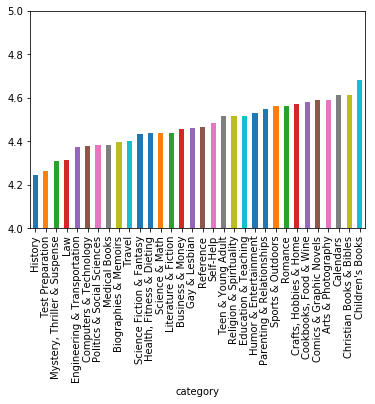

In [44]:
plt.ylim(4, 5)
rating_per_cat.plot(kind="bar")

In [45]:
df_cat["category"].unique()

array(['Cookbooks, Food & Wine', 'Religion & Spirituality', 'History',
       'Arts & Photography', 'Health, Fitness & Dieting',
       'Humor & Entertainment', 'Engineering & Transportation', 'Travel',
       'Literature & Fiction', "Children's Books",
       'Politics & Social Sciences', 'Crafts, Hobbies & Home',
       'Parenting & Relationships', 'Romance', 'Business & Money',
       'Reference', 'Teen & Young Adult', 'Biographies & Memoirs',
       'Christian Books & Bibles', 'Sports & Outdoors', 'Science & Math',
       'Law', 'Medical Books', 'Self-Help',
       'Mystery, Thriller & Suspense', 'Computers & Technology',
       'Comics & Graphic Novels', 'Science Fiction & Fantasy',
       'Test Preparation', 'Education & Teaching', 'Gay & Lesbian',
       'Calendars'], dtype=object)

We define new categories.

In [46]:
new_cat = dict()
new_cat["Health & lifestyle"] = ["Cookbooks, Food & Wine", 
                                 "Health, Fitness & Dieting",
                                 "Sports & Outdoors",
                                 "Self-Help",
                                 "Travel"]
new_cat["History & Religion"] = ["History", 
                                 "Biographies & Memoirs",
                                 "Religion & Spirituality", 
                                 "Christian Books & Bibles"]
new_cat["Arts"] = ["Arts & Photography", 
                   "Crafts, Hobbies & Home",
                   "Calendars"]
new_cat["Engineering & Science"] = ["Engineering & Transportation", 
                                    "Business & Money",
                                    "Science & Math",
                                    "Law",
                                    "Test Preparation",
                                    "Computers & Technology",
                                    "Medical Books"]
new_cat["Literature"] = ["Literature & Fiction", 
                         "Mystery, Thriller & Suspense",
                         "Science Fiction & Fantasy",
                         "Romance"]
                         
new_cat["Entertainment"] = ["Children's Books",
                             "Humor & Entertainment",
                             "Comics & Graphic Novels",
                             "Teen & Young Adult"]
new_cat["Social sciences"] = ["Politics & Social Sciences",
                              "Parenting & Relationships",
                              "Education & Teaching",
                              "Gay & Lesbian"]
new_cat["Other"] = ["Reference"]

cat_to_new_cat = dict()
for key, value in new_cat.items():
    for cat in value:
        cat_to_new_cat[cat] = key

def compute_new_cat(category):
    return cat_to_new_cat[category]



In [47]:
df["new category"] = df["category"].map(compute_new_cat)

In [48]:
test = df[df["category"] == "Test Preparation"]["product_title"].unique()
for i in range(len(test)):
    print(test[i])

The Encyclopedia of Infant and Toddlers Activities for Children Birth to 3: Written by Teachers for Teachers
TABE Secrets Study Guide: TABE Exam Review for the Test of Adult Basic Education
Kaplan GMAT in a Box
ACT Exam Secrets Study Guide: ACT Test Review for the ACT Test
NCLEX-RN Medication Flashcards
500+ Practice Questions for the New SAT: Created for the Redesigned 2016 Exam (College Test Preparation)
Obstetrics and Gynecology
Pance Prep Pearls
Pearson Reviews & Rationales: Comprehensive Review for NCLEX-RN (2nd Edition) (Hogan, Pearson Reviews & Rationales Series)
GRE Premier 2016 with 6 Practice Tests: Book + Online + DVD + Mobile
Barron's Court Officer Exam, 3rd Edition
Electrician's Exam Study Guide 2/E
A Guide to the Project Management Body of Knowledge (PMBOK® Guide)Fifth Edition
Praxis II Early Childhood: Content Knowledge Practice Questions: Praxis II Practice Tests & Review for the Praxis II: Subject Assessments
5 lb. Book of GRE Practice Problems (Manhattan Prep GRE Str

In [49]:
df_cat["new category"] = df_cat["category"].map(compute_new_cat)

In [50]:
df_cat["new category"].value_counts()

Health & lifestyle       11178
Engineering & Science    10499
Entertainment             7176
History & Religion        6524
Arts                      5495
Literature                3878
Social sciences           2284
Other                      942
Name: new category, dtype: int64

In [51]:
rating_per_cat = df_cat.groupby(["new category"])["avg_rating"].mean().sort_values()

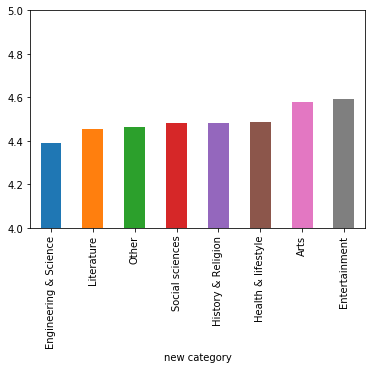

In [52]:
plt.ylim(4, 5)
rating_per_cat.plot(kind="bar")

Les livres de divertissement et d'art semble plus apprécié que les livres plus sérieux traitant des sciences. Nous pouvons supposé que les premiers sont pour se détendre, pour le loisir, alors que les seconds sont pour le travail. Les gens sont plus disposés à apprécié quelque chose qui est fait pour les divertir

In [53]:
# Colors

In [54]:
df_cat["dominant_color1"] = df.groupby(["product_id"])["dominant_color1"].unique()
df_cat["dominant_color2"] = df.groupby(["product_id"])["dominant_color2"].unique()

In [55]:
df_cat["dominant_color1"] = df_cat["dominant_color1"].apply(lambda x: x[0])
df_cat["dominant_color2"] = df_cat["dominant_color2"].apply(lambda x: x[0])

In [56]:
df_cat.head()

,category,avg_rating,new category,dominant_color1,dominant_color2
product_id,,,,,
000215949X,"Cookbooks, Food & Wine",4.704918,Health & lifestyle,#9a6324,#9a6324
000712032X,Religion & Spirituality,5.000000,History & Religion,#800000,#800000
000712693X,History,4.571429,History & Religion,#f58231,#f58231
000713326X,Arts & Photography,4.773585,Arts,#ffffff,#ffffff
000716050X,"Health, Fitness & Dieting",4.714286,Health & lifestyle,#a9a9a9,#a9a9a9


In [57]:
# Initialize dictionaries
colors_per_cat = dict()
for cat in df_cat["new category"].unique():
    colors_per_cat[cat] = dict()
    for color in colors_dict:
        colors_per_cat[cat][color] = 0
        
for i in range(len(df_cat)):
    colors_per_cat[df_cat['new category'][i]][df_cat['dominant_color1'][i]] += 1
    colors_per_cat[df_cat['new category'][i]][df_cat['dominant_color2'][i]] += 1

In [58]:
colors_per_cat["Health & lifestyle"]

{'#ff0000': 857,
 '#f58231': 1055,
 '#ffff00': 1099,
 '#00ff00': 164,
 '#008000': 572,
 '#42d4f4': 819,
 '#0000ff': 903,
 '#911eb4': 408,
 '#f032e6': 119,
 '#a9a9a9': 2091,
 '#000000': 4132,
 '#ffffff': 6919,
 '#800000': 1048,
 '#9a6324': 883,
 '#469990': 619,
 '#000075': 668}

In [59]:
df_colors_per_cat = pd.DataFrame()
data = sorted(colors_dict.items())
color, _ = zip(*data)
df_colors_per_cat["Color"] = color
    
for key in new_cat:
    data = sorted(colors_per_cat[key].items())
    _, count = zip(*data)
    df_colors_per_cat[key] = count
    df_colors_per_cat[key] = df_colors_per_cat[key] / df_colors_per_cat[key].sum()
df_colors_per_cat = df_colors_per_cat.set_index(["Color"], drop=True)

In [60]:
df_colors_per_cat.head()

,Health & lifestyle,History & Religion,Arts,Engineering & Science,Literature,Entertainment,Social sciences,Other
Color,,,,,,,,
#000000,0.184827,0.279353,0.237216,0.216021,0.401625,0.237040,0.178853,0.156051
#000075,0.029880,0.040389,0.021474,0.057958,0.032233,0.027801,0.033932,0.037155
#0000ff,0.040392,0.029123,0.024386,0.057767,0.023853,0.027244,0.037653,0.041401
#008000,0.025586,0.018930,0.034304,0.026383,0.013538,0.023899,0.021891,0.028662
#00ff00,0.007336,0.002836,0.005823,0.006905,0.002837,0.007386,0.010508,0.007962


In [61]:
color_labels = list(df_colors_per_cat.index.map(get_color_name))

In [62]:
new_cat_list = df_cat["new category"].unique()

In [63]:
new_cat_list

array(['Health & lifestyle', 'History & Religion', 'Arts',
       'Entertainment', 'Engineering & Science', 'Literature',
       'Social sciences', 'Other'], dtype=object)

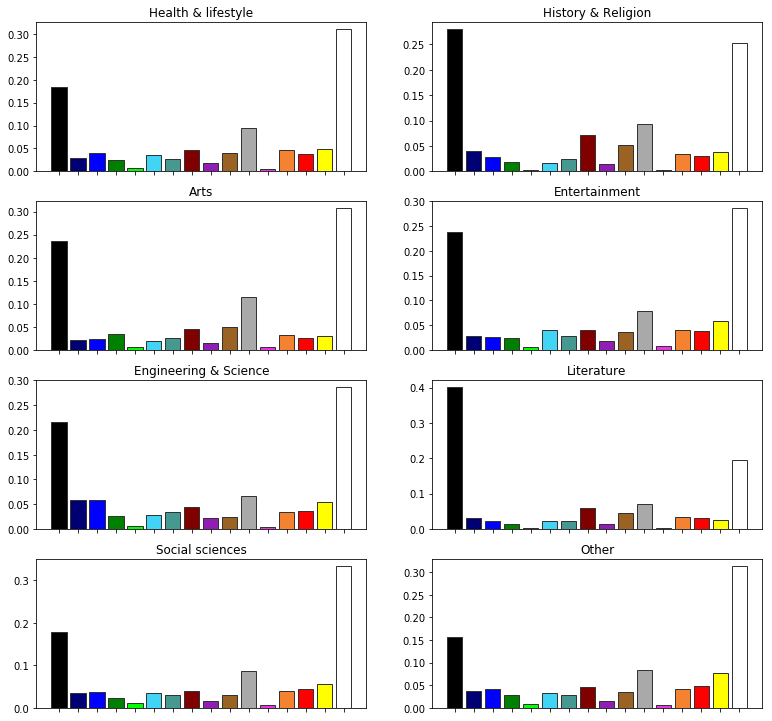

In [64]:
fig=plt.figure(figsize=(13, 14))
columns = 2
rows = 4
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.bar(df_colors_per_cat.index, 
        df_colors_per_cat[new_cat_list[i-1]], 
        color=df_colors_per_cat.index, 
        edgecolor="#333333")
    fig.autofmt_xdate()
    ax.set_title(new_cat_list[i-1])
    _ = ax.set_xticklabels([])
plt.savefig('foo.png')
plt.show()

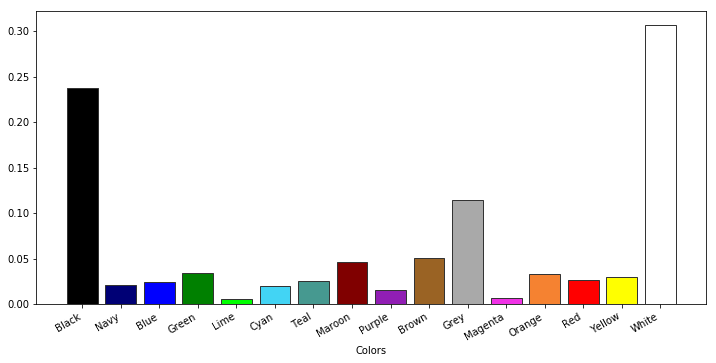

In [65]:
fig,ax = plt.subplots(1, figsize=(12, 6))
plt.bar(df_colors_per_cat.index, 
        df_colors_per_cat["Arts"], 
        color=df_colors_per_cat.index, 
        edgecolor="#333333")
fig.autofmt_xdate()
ax.set_xlabel("Colors")
_ = ax.set_xticklabels(color_labels)
plt.show()

Let's have a look to the brightness

In [66]:
df_cat["brightness"] = df.groupby(["product_id"])["brightness"].unique()

In [67]:
df_cat["brightness"] = df_cat["brightness"].apply(lambda x: x[0])

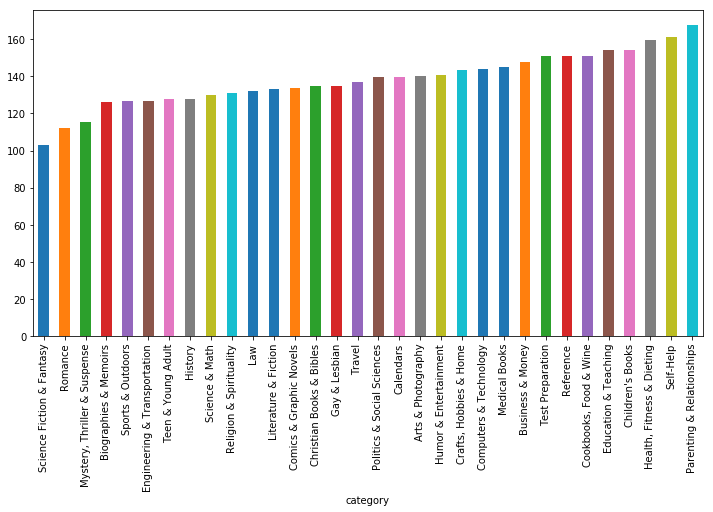

In [68]:
cat_to_brightness = df_cat.groupby(["category"])["brightness"].mean().sort_values()
plt.figure(figsize=(12, 6))
cat_to_brightness.plot(kind='bar')

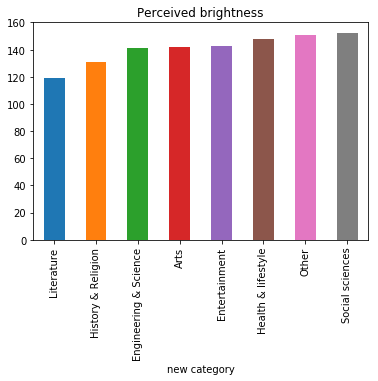

In [69]:
cat_to_brightness = df_cat.groupby(["new category"])["brightness"].mean().sort_values()
cat_to_brightness.plot(kind='bar', title='Perceived brightness')

Now we want to compare the color distribution between low rating to the high rating for each category

In [70]:
df_low = df[df["rating_adjusted"] == 1]

In [71]:
color1 = df_low.groupby(["new category"])["dominant_color1"].apply(list)
color2 = df_low.groupby(["new category"])["dominant_color2"].apply(list)

In [72]:
color = (color1+color2).to_frame()
color.columns = ["low_rating"]

In [73]:
df_high = df[df["rating_adjusted"] == 5]
color1 = df_high.groupby(["new category"])["dominant_color1"].apply(list)
color2 = df_high.groupby(["new category"])["dominant_color2"].apply(list)

In [74]:
color["high_rating"] = (color1+color2)

In [75]:
color

,low_rating,high_rating
new category,,
Arts,"[#ffffff, #ffffff, #ffffff, #ffffff, #ffffff, ...","[#ffffff, #ffffff, #ffffff, #ffffff, #ffffff, ..."
Engineering & Science,"[#9a6324, #9a6324, #000000, #000000, #000000, ...","[#9a6324, #9a6324, #9a6324, #9a6324, #9a6324, ..."
Entertainment,"[#000000, #000000, #000000, #000000, #000000, ...","[#911eb4, #911eb4, #911eb4, #911eb4, #911eb4, ..."
Health & lifestyle,"[#ffffff, #ffffff, #ffffff, #ffffff, #ffffff, ...","[#ffffff, #ffffff, #ffffff, #ffffff, #ffffff, ..."
History & Religion,"[#9a6324, #000000, #000000, #000000, #000000, ...","[#9a6324, #9a6324, #9a6324, #9a6324, #9a6324, ..."
Literature,"[#000000, #000000, #000000, #000000, #000000, ...","[#000000, #000000, #000000, #000000, #000000, ..."
Other,"[#ffffff, #ffffff, #ffffff, #ffffff, #ffffff, ...","[#ffffff, #ffffff, #ffffff, #ffffff, #ffffff, ..."
Social sciences,"[#000075, #000075, #000075, #000075, #000075, ...","[#000075, #000075, #000075, #000075, #000075, ..."


In [76]:
rate_per_cat = dict()

In [77]:
for key in new_cat:
    cat = pd.Series(color.loc[key, "low_rating"]).value_counts().sort_index().to_frame(name="1")
    cat["5"] = pd.Series(color.loc[key, "high_rating"]).value_counts().sort_index()
    cat["1"] = cat["1"] / cat["1"].sum()
    cat["5"] = cat["5"] / cat["5"].sum()
    rate_per_cat[key] = cat

In [78]:
color_labels = list(color_df.index.map(get_color_name))

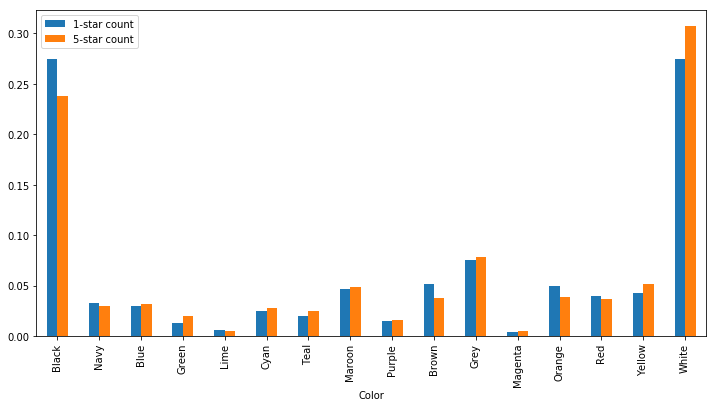

In [79]:
ax = color_df[["1-star count", "5-star count"]].plot(kind="bar", figsize=(12, 6))
_ = ax.set_xticklabels(color_labels)

In [80]:
new_cat_list

array(['Health & lifestyle', 'History & Religion', 'Arts',
       'Entertainment', 'Engineering & Science', 'Literature',
       'Social sciences', 'Other'], dtype=object)

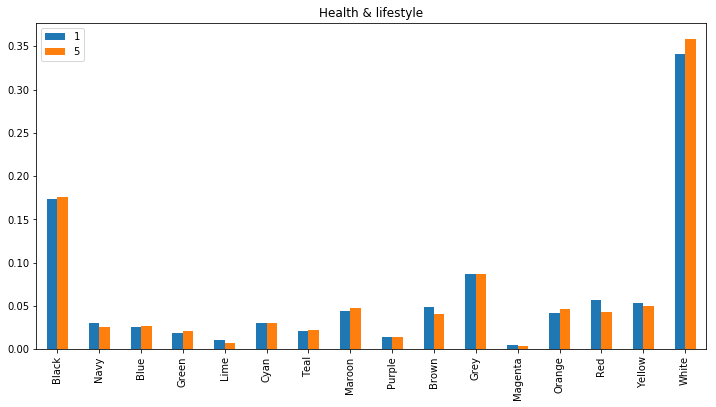

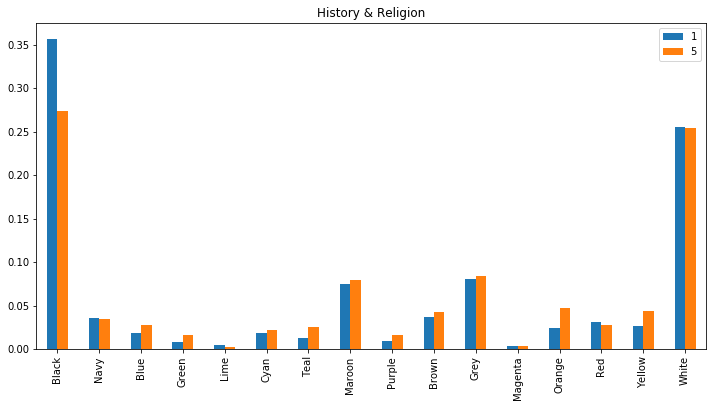

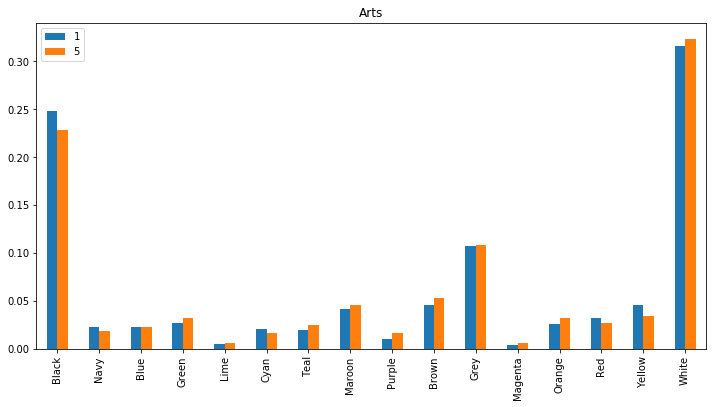

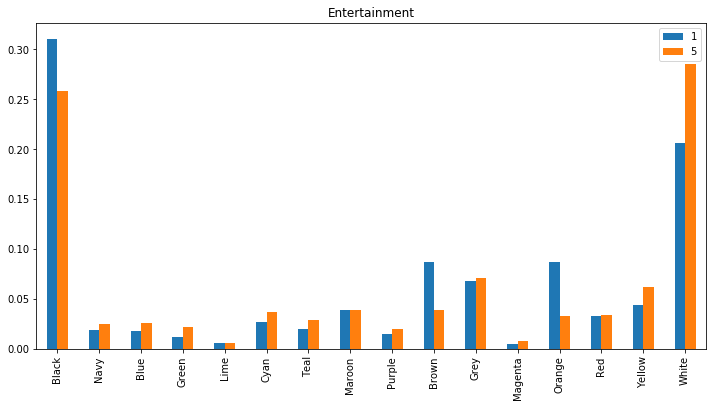

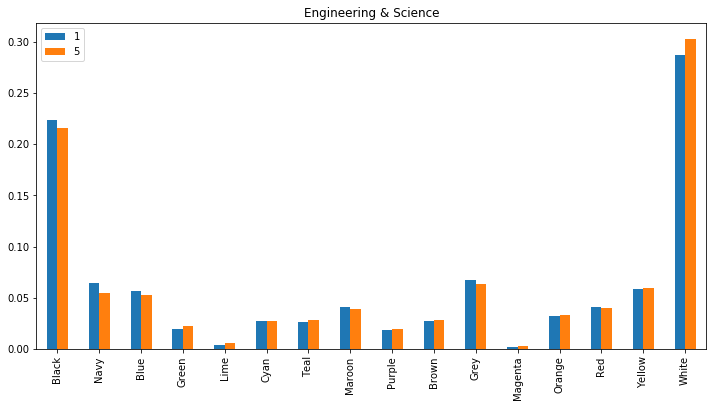

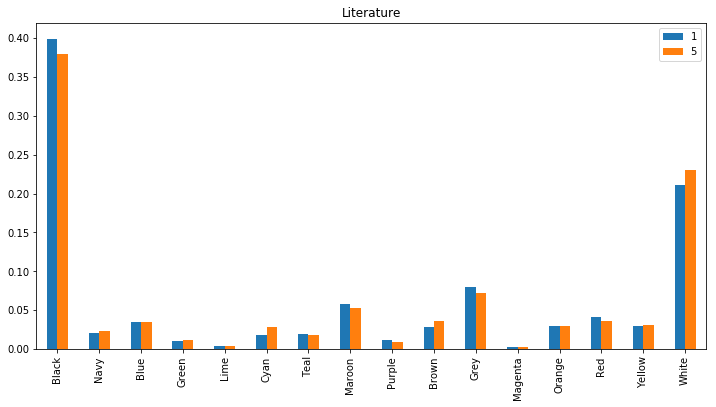

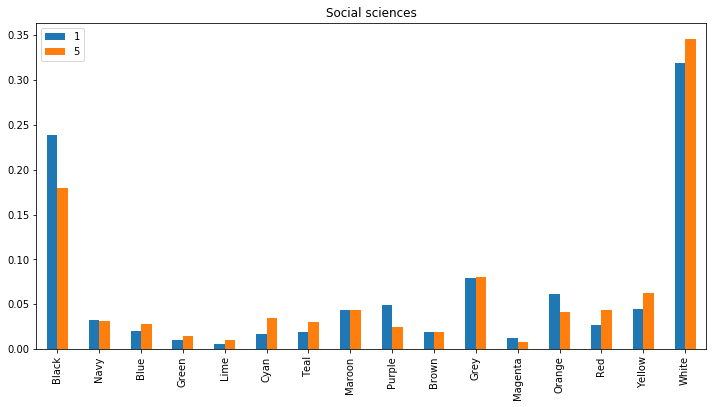

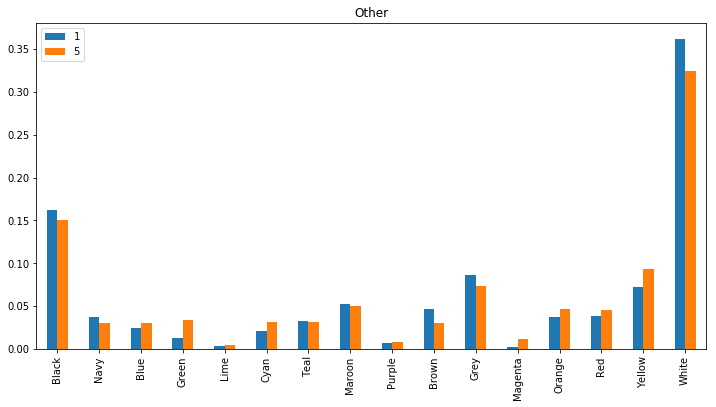

In [81]:
for i in range(len(new_cat_list)):
    ax = rate_per_cat[new_cat_list[i]].plot(kind="bar", figsize=(12, 6))
    _ = ax.set_xticklabels(color_labels)
    _ = ax.set_title(new_cat_list[i])

In [82]:
cat_brightness = df[df["rating_adjusted"] == 1].groupby(["new category"])["brightness"].mean().sort_values().to_frame(name="Low rating")
cat_brightness["High rating"] = df[df["rating_adjusted"] == 5].groupby(["new category"])["brightness"].mean().sort_values()

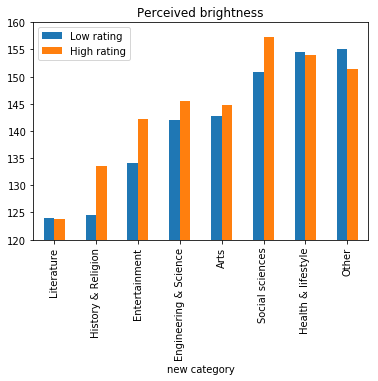

In [83]:
cat_brightness.plot(kind='bar', title='Perceived brightness', ylim=(120, 160))